In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Handle any runtime initialization errors

2024-10-21 10:57:41.289414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-21 10:57:41.309115: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-21 10:57:41.315162: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-21 10:57:41.330104: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-21 10:57:45.215087: W tensorflow/compiler/tf2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import jax
from pathlib import Path

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [4]:
import re

def extract_number(string):
    # Use regular expression to find a number inside parentheses
    match = re.search(r'\((\d+)\s+replicas\)', string)
    if match:
        return int(match.group(1))  # Return the number as an integer
    else:
        return None  # Return None if no match is found

In [22]:
def plot_experiments(experiment_folders,rounded = False,adjust=True,time_scaling=False):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.set_xlabel('Iteration (adjusted)')  # Change this as appropriate
    ax.set_ylabel('Objective')
    ax.set_title('Objective with error bars (std)')
    
    for experiment_folder in experiment_folders:
        
        directory = Path(f'{experiment_folder}')
        results = {}
        for folder in directory.iterdir():
            if folder.is_dir():
                try:
                    experiment_name = str(folder)[len(experiment_folder)+1:]
                    if experiment_name[0] != '.':
                        with open(f'{experiment_folder}/{experiment_name}/results.pkl', 'rb') as file:
                            results[experiment_name] = pickle.load(file)
                except:
                    print(f'Error loading {experiment_name}')
        result_dfs = []

        exp_times = {}
        for exp in results:
            df = pd.DataFrame({'mean_objective': np.mean(np.floor(results[exp]['trajectory']+1e-5),axis=1) if rounded else np.mean(results[exp]['trajectory'],axis=1),
                               'std_objective': np.std(results[exp]['trajectory'],axis=1),
                               'experiment': f'{experiment_folder}: {exp}',
                               'running time': results[exp]['running_time']})
            result_dfs.append(df)
            print(f'running time for {exp}: {results[exp]["running_time"]/60:.2f}min')
            exp_times[f'{experiment_folder}: {exp}'] = results[exp]["running_time"]
        df = pd.concat(result_dfs)

        mean_df = df.pivot(values='mean_objective',columns='experiment')
        std_df = df.pivot(values='std_objective',columns='experiment')
        
        # Loop through each column and plot the mean with the shaded area
        for column in mean_df.columns:
            if adjust:
                number = extract_number(column) if extract_number(column) else 1
            else:
                number = 1
            scaling = number*10

            if time_scaling:
                scaling = 1/mean_df[column].dropna().index[-1]*exp_times[column]
            
            ax.plot(mean_df.index*scaling, mean_df[column], label=column)
            ax.fill_between(mean_df.index*scaling, 
                            mean_df[column] - std_df[column], 
                            mean_df[column] + std_df[column], 
                            alpha=0.3)  # alpha for transparency
        
    # Adding labels, title, and legend
    ax.set_xlim(1,)
    final_val = mean_df.iloc[-1].max()
    ax.set_ylim(0.9*final_val,1.1*final_val)
    #ax.set_ylim(0,200)
    ax.grid()
    ax.legend()
    #ax.set_xscale('log')
    if time_scaling:
        ax.set_xlabel('Running time (s)')
    plt.show()
    #fig.savefig(experiment_folder+'/plot.png')
    return mean_df, results

running time for replica exchange (15 replicas) (proper): 167.60min
running time for replica exchange (15 replicas): 147.67min
running time for replica exchange (15 replicas) (adaptive): 168.41min
running time for exp decaying temperature: 96.57min


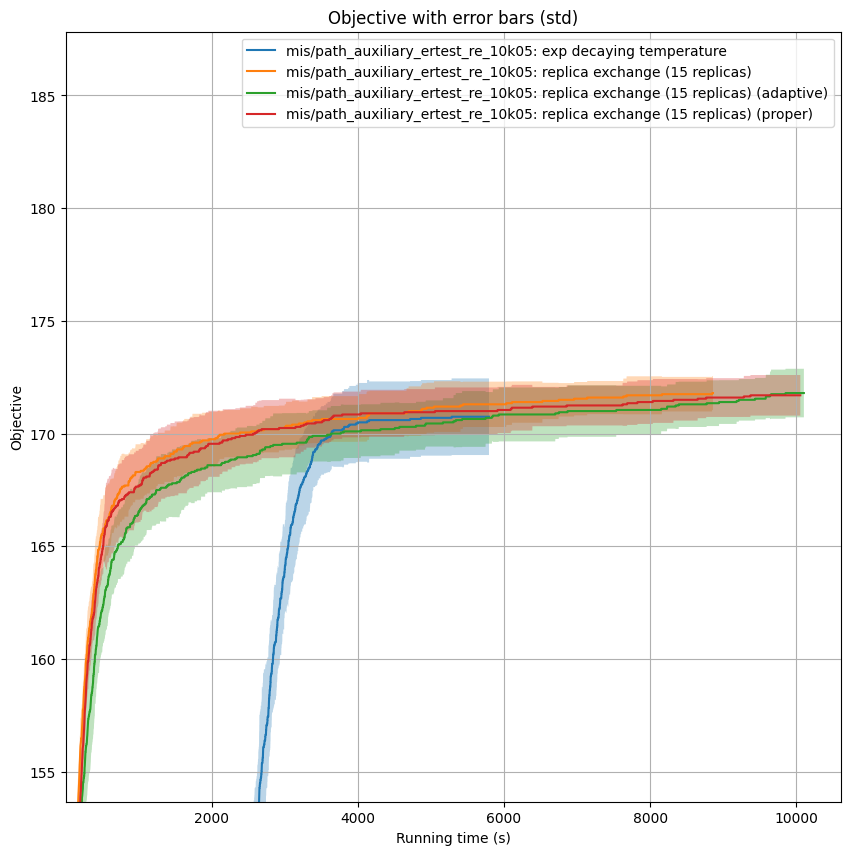

In [32]:
mean_df, results = plot_experiments(['mis/path_auxiliary_ertest_re_10k05'],rounded=False,adjust=False,time_scaling=True)
#mean_df = plot_experiments(['maxcut/path_auxiliary_ba_adaptivetemp'],rounded=False,adjust=False)

In [36]:
mean_df.agg(lambda x: x.dropna().iloc[-1]) 

experiment
mis/path_auxiliary_ertest_re_10k20: exp decaying temperature          46.125004
mis/path_auxiliary_ertest_re_10k20: replica exchange (20 replicas)    47.375000
dtype: float32

(5000, 8)
(20000, 8)


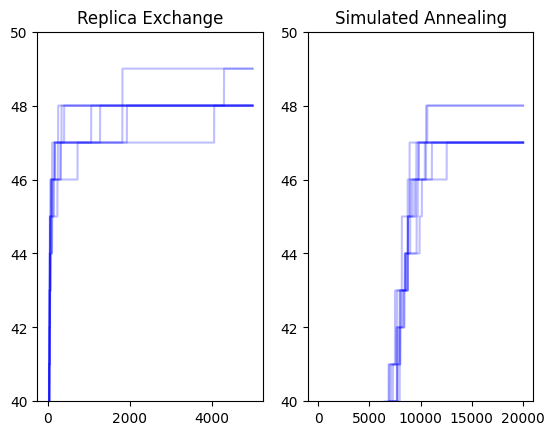

In [9]:
#experiment_name = 'exp decaying temperature'
fig, ax = plt.subplots(1,2)
experiment_name = 'replica exchange (20 replicas)'
experiment_folder = 'mis/path_auxiliary_ertest_re_10k20_big'
with open(f'{experiment_folder}/{experiment_name}/results.pkl', 'rb') as file:
    # Load the object from the file
    results = pickle.load(file)
trajectory = results['trajectory']
df = pd.DataFrame(trajectory)
#ax.set_ylim(0.999999,1)
df.loc[:,:].plot(ax=ax[0],alpha=.25,color='blue',legend=False)
ax[0].set_title('Replica Exchange')
print(df.shape)

experiment_name = 'exp decaying temperature'
with open(f'{experiment_folder}/{experiment_name}/results.pkl', 'rb') as file:
    # Load the object from the file
    results = pickle.load(file)
trajectory = results['trajectory']
df = pd.DataFrame(trajectory)
#ax.set_ylim(0.999999,1)
df.loc[:,:].plot(ax=ax[1],alpha=.25,color='blue',legend=False)
ax[1].set_title('Simulated Annealing')

for subax in ax:
    subax.set_ylim(40,50)
print(df.shape)

In [15]:
results['best_ratio'].shape

(8,)

In [16]:
(df.iloc[-1,:]<=.9999999).mean()

0.0

<Axes: >

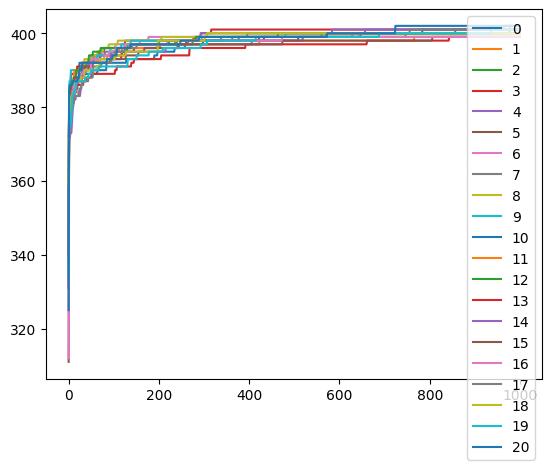

In [17]:
experiment_name = 'replica exchange (15 replicas)'
experiment_folder = 'mis/dlmc_satlib_re_many_big'
with open(f'{experiment_folder}/{experiment_name}/results.pkl', 'rb') as file:
    # Load the object from the file
    results = pickle.load(file)
trajectory = results['trajectory']
df = pd.DataFrame(trajectory)
df.loc[:,:20].plot()

In [20]:
experiment_name = 'replica exchange (20 replicas)'
experiment_folder = 'mis/path_auxiliary_ertest_re_10k20_big'
with open(f'{experiment_folder}/{experiment_name}/swap_probs.pkl', 'rb') as file:
    # Load the object from the file
    swap_probs=pickle.load(file)

swap_probs = swap_probs['array']

In [21]:
swap_probs.shape

(5000, 19, 2, 4, 1)

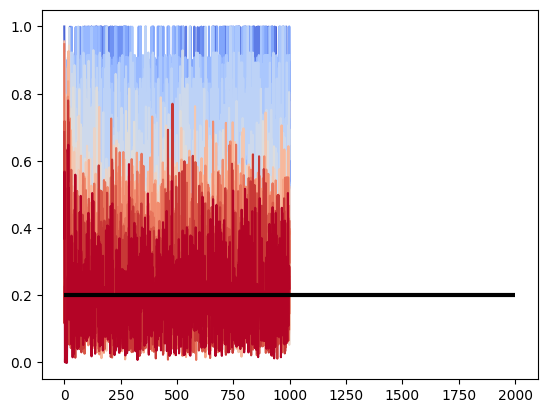

In [22]:
num_colors = swap_probs.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(swap_probs.mean(axis=[2,3,4])[:1000,i], color = colors[i])

plt.hlines(0.2,0,2000,color='black',lw=3)

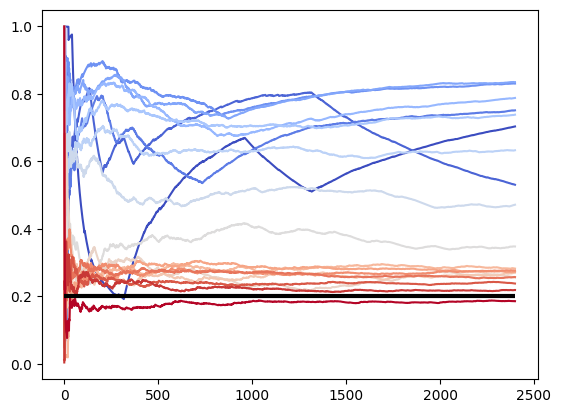

In [23]:
init = 100
num_colors = swap_probs.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(np.cumsum(swap_probs[init:swap_probs.shape[0]//2,i,0,5,0],axis=0)/(1+np.arange(swap_probs.shape[0]//2-init)), color=colors[i])

plt.hlines(0.2,0,swap_probs.shape[0]//2-init,color='black',lw=3)

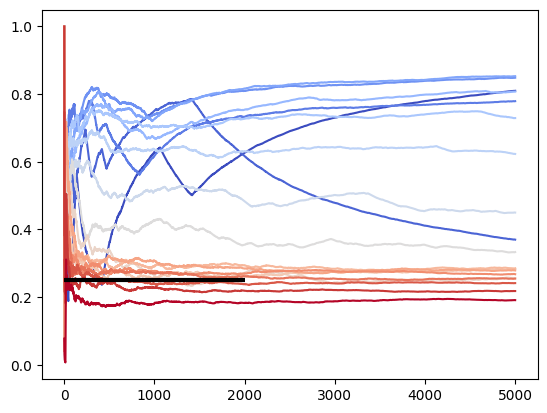

In [24]:
#### num_colors = swap_probs.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(np.cumsum(swap_probs[:,i,0,6,0],axis=0)/(1+np.arange(swap_probs.shape[0])), color=colors[i])

plt.hlines(0.25,0,2000,color='black',lw=3)

In [19]:
experiment_name = 'replica exchange (20 replicas)'
experiment_folder = 'mis/path_auxiliary_ertest_re_10k20'
with open(f'{experiment_folder}/{experiment_name}/energies.pkl', 'rb') as file:
    # Load the object from the file
    energies=pickle.load(file)

energies = energies['array']

In [20]:
energies.shape

(1000, 20, 2, 4, 1)

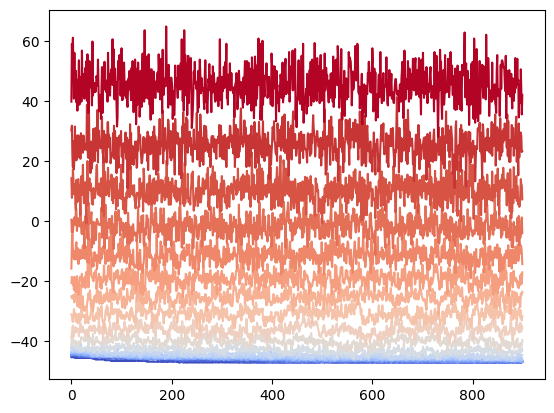

In [27]:
num_colors = energies.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(energies.mean(axis=[3,4])[100:,i,0], color = colors[i])


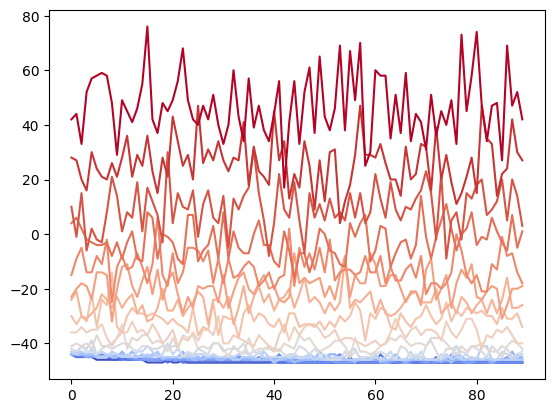

In [29]:
num_colors = energies.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(energies[100::10,i,0,1,30], color = colors[i])

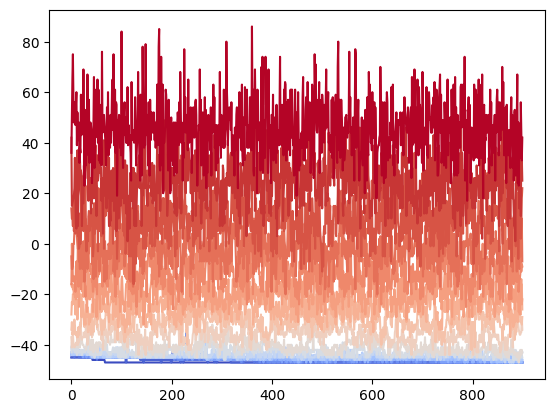

In [30]:
num_colors = energies.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(energies[100:,i,0,6,0], color = colors[i])

In [31]:
import seaborn as sns

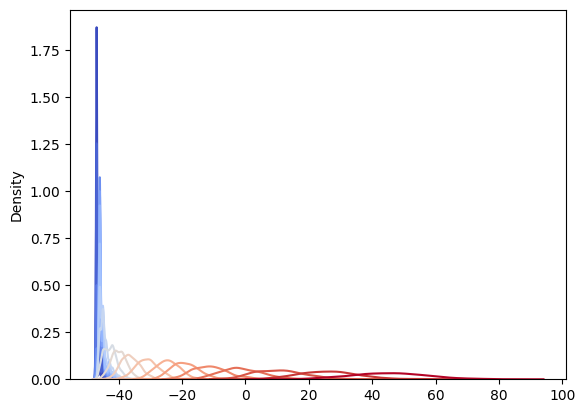

In [34]:
num_colors = energies.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))

for i in range(num_colors):
    sns.kdeplot(energies[50:,i,0,0,0], label = f'Temp {i}', color=colors[i])

#plt.yscale('log')


In [70]:
experiment_name = 'replica exchange (5 replicas) (adaptive)'
experiment_folder = 'maxcut/path_auxiliary_ba_test'
with open(f'{experiment_folder}/{experiment_name}/temp_tracker.pkl', 'rb') as file:
    # Load the object from the file
    temp_tracker=pickle.load(file)

temp_tracker = temp_tracker['array']

In [71]:
temp_tracker.shape

(1000, 5, 2, 512, 2)

In [72]:
np.min(temp_tracker[:100,13,0,0,0])

Array(0.05000001, dtype=float32)

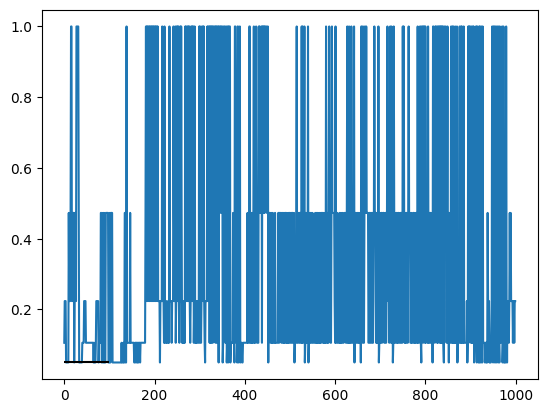

In [73]:
plt.plot(temp_tracker[:,2,0,4,0])
plt.hlines(0.05,0,100,color='black')

In [6]:
experiment_name = 'replica exchange (15 replicas) (adaptive)'
experiment_folder = 'mis/path_auxiliary_ertest_re_10k05'
with open(f'{experiment_folder}/{experiment_name}/temps.pkl', 'rb') as file:
    # Load the object from the file
    temps=pickle.load(file)

temps = temps['array']

In [8]:
def flatten_index_to_multi_dim(flattened_index, shape):
    indices = []
    for dim in reversed(shape):
        indices.append(flattened_index % dim)
        flattened_index //= dim
    return tuple(reversed(indices))

In [9]:
flatten_index_to_multi_dim(4485088,temps.shape)

(50, 4, 0, 8, 0)

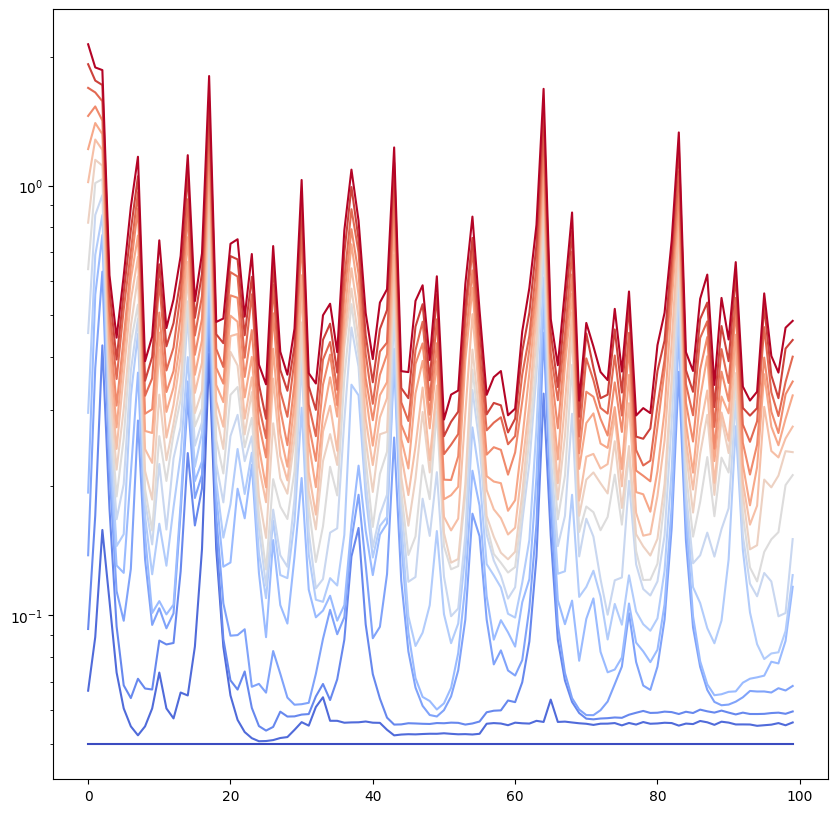

In [14]:
fig, ax = plt.subplots(figsize=(10,10))
num_colors = temps.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    ax.plot(temps[:,i,0,0,0], color = colors[i])

#ax.set_ylim(0.05,1)
ax.set_yscale('log')

(-200.0, -100.0)

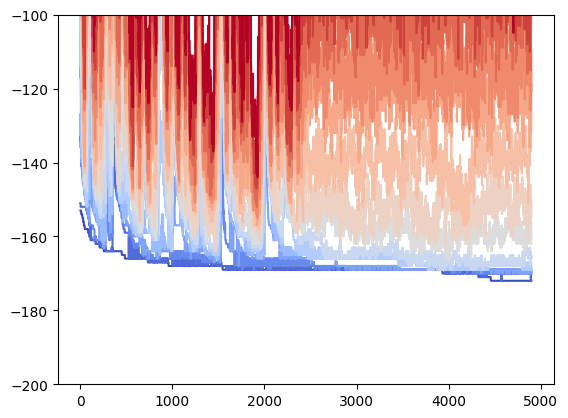

In [18]:
with open(f'{experiment_folder}/{experiment_name}/energies.pkl', 'rb') as file:
    # Load the object from the file
    energies=pickle.load(file)

energies = energies['array']

num_colors = energies.shape[1]
colors = plt.cm.coolwarm(np.linspace(0, 1, num_colors))
for i in range(num_colors):
    plt.plot(energies[100:,i,0,0,0], color = colors[i])

plt.ylim(-200,-100)


In [128]:
swap_probs[200:,].mean(axis=[2,3,4]).mean(axis=0)

Array([0.15662347, 0.0850835 , 0.03012249, 0.00421689, 0.003205  ,
       0.00545204, 0.00827458, 0.01161465, 0.01225791], dtype=float32)

In [34]:
state = {'num_ll_calls': 2,
         'parameter': 3}

In [38]:
state_keys = state.keys()
state_array = jnp.array([state[key] for key in state_keys])
repeated_state_array = jnp.expand_dims(state_array, axis=0)
full_state_array = jnp.repeat(repeated_state_array, repeats=10,axis=0)

In [45]:
state_keys = list(state_keys)

In [46]:
{state_keys[j]: full_state_array[3][j] for j in range(len(state_keys))}

{'num_ll_calls': Array(2, dtype=int32), 'parameter': Array(3, dtype=int32)}

In [32]:
repeated_x = jnp.expand_dims(x, axis=0)
full_x = jnp.repeat(repeated_x, repeats=3,axis=0)

In [33]:
full_x

Array([[1, 2],
       [1, 2],
       [1, 2]], dtype=int32)

In [23]:
import jax.numpy as jnp

In [26]:
d = {'a': 0,
 'b': 1}

jnp.array([d[i] for i in d.keys()])

Array([0, 1], dtype=int32)

In [28]:
jnp.repeat(jnp.array([1,2,3]),2)

Array([1, 1, 2, 2, 3, 3], dtype=int32)

In [72]:
np.exp(-1/.4)

0.0820849986238988

In [88]:
experiment_name = 'bernoulli_hightemp'

with open(f'{experiment_name}/samples.pkl', 'rb') as file:
    # Load the object from the file
    samples = pickle.load(file)['trajectory']

with open(f'{experiment_name}/params.pkl', 'rb') as file:
    # Load the object from the file
    params = pickle.load(file)['params']

In [89]:
samples.shape

(10000, 4, 10)

In [90]:
1/(1+np.exp(params))

array([0.48286   , 0.5026763 , 0.54163533, 0.39785805, 0.3373209 ,
       0.5768507 , 0.487088  , 0.41803205, 0.39282462, 0.6176615 ],
      dtype=float32)

In [91]:
samples = np.array(samples)

In [92]:
samples[1000:,2,0].mean()

0.12566666666666668

In [69]:
samples[:,1,0].mean()

Array(0.2819, dtype=float32)

In [94]:
rng = jax.random.PRNGKey(0)

In [97]:
keys = jax.random.split(rng,5)

In [100]:
jax.vmap(jax.random.normal)(keys)

Array([-0.9204866 , -0.738873  ,  1.6133053 , -1.5701252 , -0.55517924],      dtype=float32)

In [ ]:
import importlib
from absl import app
from absl import flags
from discs.common import configs as common_configs
from discs.common import utils
import discs.common.experiment_saver as saver_mod
from ml_collections import config_flags

In [146]:
# CONFIG
model_name = 'mis'
experiment_name = 'exponential'
sampler_name = 'randomwalk'
graph_type = 'ertest'

experiment_config = importlib.import_module(
        f'discs.experiment.configs.{model_name}.{graph_type}'
    )
experiment_config = experiment_config.get_config()

model_config = importlib.import_module(
        f'discs.models.configs.{model_name}_config'
    )

model_config = model_config.get_config()

sampler_config = importlib.import_module(
        f'discs.samplers.configs.{sampler_name}_config'
    )

sampler_config = sampler_config.get_config()

In [147]:
def get_main_config():
  """Merge experiment, model and sampler config."""
  config = common_configs.get_config()
  if (
      'graph_type' not in model_config
      and 'bert_model' not in model_config
  ):
    config.update(experiment_config)
  config.sampler.update(sampler_config)
  config.model.update(model_config)
  if config.model.get('graph_type', None):
    graph_config = importlib.import_module(
        'discs.models.configs.%s.%s'
        % (config.model['name'], config.model['graph_type'])
    )
    config.model.update(graph_config.get_model_config(config.model['cfg_str']))
    co_exp_default_config = importlib.import_module(
        'discs.experiment.configs.co_experiment'
    )
    config.experiment.update(co_exp_default_config.get_co_default_config())
    config.update(experiment_config)
    config.experiment.num_models = config.model.num_models

  if config.model.get('bert_model', None):
    config.update(experiment_config)

  return config

In [150]:
config = get_main_config()

In [153]:
config.get('samplser',0)

0

In [158]:
config.update({'experiment':{'test':'jup'}})

In [159]:
config

experiment:
  batch_size: 32
  chain_length: 50000
  co_opt_prob: true
  decay_rate: 0.01
  ess_ratio: 0.5
  evaluator: co_eval
  fig_folder: ''
  final_temperature: 0.0001
  get_additional_metrics: false
  get_estimation_error: false
  init_temperature: 1
  log_every_steps: 100
  name: CO_Experiment
  num_models: 128
  plot_every_steps: 10
  run_parallel: true
  save_every_steps: 100
  save_root: ''
  save_samples: false
  shuffle_buffer_size: 0
  t_schedule: exp_decay
  test: jup
  use_tqdm: false
  window_size: 10
  window_stride: 10
experiment_name: test
model:
  cfg_str: r-800
  data_root: ./sco/
  graph_type: ertest
  max_num_edges: 47885
  max_num_nodes: 800
  name: mis
  num_categories: 2
  num_instances: 128
  num_models: 128
  penalty: 1.001
  rand_type: '800'
  save_dir_name: mis
  shape: !!python/tuple
  - 0
sampler:
  adaptive: true
  name: randomwalk
  target_acceptance_rate: 0.237

In [160]:
experiments = [{'experiment_name': 'exp_temp_decay',
                'experiment': {'t_schedule': 'exp_decay'}},
                {'experiment_name': 'high_temp',
                'experiment': {'t_schedule': 'constant',
                               'init_temperature': 1}},
                {'experiment_name': 'high_temp',
                'experiment': {'t_schedule': 'constant',
                               'init_temperature': 0.01}}]

In [167]:
experiment ={'experiment_name': 'high_temp',
                'experiment': {'t_schedule': 'constant',
                               'init_temperature': 1}}

In [168]:
config.update(experiment)

In [32]:
def square(x):
    return x**2

In [34]:
square(1 if False else 2)

4

In [76]:
def get_xi(x,i):
    return x[i]

In [77]:
func = jax.vmap(first_comp)

In [78]:
array = jax.numpy.arange(20).reshape([5,4])

In [80]:
array

Array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15],
       [16, 17, 18, 19]], dtype=int32)

In [82]:
get_xi(array,jax.numpy.array([0,0,0,0]))

Array([[0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3],
       [0, 1, 2, 3]], dtype=int32)

In [18]:
class Parent:
    def __init__(self):
        print("Parent __init__ called")

class Child(Parent):
    pass

# Initialize Child
child_instance = Child()

Parent __init__ called


In [24]:
from jax import numpy as jnp

In [89]:
test = jnp.arange(200)

In [92]:
test_x = jnp.reshape(test,(4,25,2))

In [93]:
test_x.shape

(4, 25, 2)

In [61]:
replica_labels = jnp.arange(4, dtype=jnp.int32)
repeated_replica_labels = jnp.expand_dims(replica_labels, axis=-1)
replica_labels = jnp.repeat(repeated_replica_labels, repeats=25,axis=-1)

In [66]:
replica_labels = replica_labels.at[1,0].set(0)
replica_labels = replica_labels.at[0,0].set(1)

In [76]:
temperatures = jnp.array([0,0.1,0.2,0.3])

In [77]:
temperatures[replica_labels]

Array([[0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
        0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
        0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
       [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3,
        0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3]],      dtype=float32)

In [80]:
particle_labels = jnp.reshape(jnp.repeat(jnp.arange(4),25),(4,-1))
particle_labels

Array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2],
       [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3]], dtype=int32)

In [103]:
jnp.expand_dims(particle_labels,axis=jnp.arange(2)+2).shape

(4, 25, 1, 1)

In [101]:
jnp.take_along_axis(test_x,particle_labels[:,:,None],axis=0)

SyntaxError: invalid syntax (3591345070.py, line 1)